### Uniaxial tensile testing with LAMMPS
Tensile testing is a widely known method for evaluating the mechanical properties of materials.
Although there are some limitations, tensile test can be used in MD simulations. 
This notebook shows a simulation of a uniaxial tensile test of 6,6-nylon using LAMMPS.
This example uses a method that deforms the cell size in the tensile direction at a given rate and a given pressure control for the plane perpendicular to the tensile direction.

<img src="./tensile.gif" width="400x">

The simulation condition is below. Note that in this example, the tensile speed is very large to save computation time.

- Model: 6,6-nylon
    - Degree of polymarization: 10
    - Number of polymers: 10
- Temperature: 300 (K)
- Pressure: 1 (atm)
- Tensile speed: 0.5^12 (1/s)
- Maximum displacement: 1000 %


### Requirements
This Notebook will demonstrate the method using LAMMPS. To ensure the proper execution of the Notebook, LAMMPS must be installed beforehand. You can find the installation instructions for both LAMMPS on Matlantis under Launchers -> Packages -> matlantis-lammps.

### Create LAMMPS input

In [4]:
lmp_data = "input/nylon.data" # total 3000 atoms
temp = 300 # K
press = 0.987 # bar, 0.987 (bar) = 1 (atm)
erate = 0.5 # 1/ps = 0.5^12 (1/s)
nsteps = 20_000

time_step = 0.001 # fs
taut = 0.1 # 0.1 ps
taup = 1.0 # 0.5 ps
traj_interval = 100 # every 100 steps
log_interval = 100 # every 100 steps

lmp_in = f"""
units metal
boundary p p p
atom_style atomic
atom_modify map yes
read_data {lmp_data}

pair_style pfp_api v5.0.0 CRYSTAL_PLUS_D3
pair_coeff * * species C H N O

timestep {time_step}

thermo {log_interval}
thermo_style custom step temp etotal pe ke lx ly lz vol press density
velocity all create {temp} 12345 dist gaussian mom yes
fix NPT all npt temp {temp} {temp} {taut} iso {press} {press} {taup}
run 10000
unfix NPT

dump 1 all custom {traj_interval} tensile.lammpstrj id type element x y z vx vy vz fx fy fz
dump_modify 1 element C H N O

thermo_style custom step elapsed temp pe ke etotal press vol density pxx pyy pzz lx ly lz
fix NPT all npt temp {temp} {temp} {taut} x {press} {press} {taup} y {press} {press} {taup} drag 1.0
fix DEFORM all deform 1 z erate {erate} units box remap x
reset_timestep 0
run {nsteps}
unfix NPT

"""

with open("tensile.in", "w") as fo:
    fo.write(lmp_in)

### Run the simulation

In [5]:
!lmp_serial -i tensile.in -log output/log.lammps

LAMMPS (29 Sep 2021 - Update 1)
Reading data file ...
  orthogonal box = (21.773139 21.773139 21.773139) to (55.081743 55.081743 55.081743)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  3880 atoms
  reading velocities ...
  3880 velocities
  read_data CPU = 0.026 seconds
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.01
  ghost atom cutoff = 2.01
  binsize = 1.005, bins = 34 34 34
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair pfp_api, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.387 | 3.387 | 3.387 Mbytes
Step Temp TotEng PotEng KinEng Lx Ly Lz Volume Press Density 
       0          300   -17179.214   -17329.634    150.42003

### Extract stress and strain from LAMMPS log

In [4]:
import pandas as pd

def parse_lammps_thermo_log(log_name):

    with open(log_name, "r") as fi:
        for i, line in enumerate(fi):
            if line.startswith("Per MPI rank memory"):
                begin = i+1
            elif line.startswith("Loop time of"):
                end = i-1
    log = pd.read_csv(log_name, sep="\s+", skiprows=begin, nrows=end-begin)
    
    return log

df = parse_lammps_thermo_log("output/log.lammps")
df["Strain"] = (df["Lz"] - df.loc[0, "Lz"])/ df.loc[0, "Lz"]*100 # engineering strain
df["Stress"] = -df["Pzz"]*0.1 # bar to MPa

### Visualize stress-strain curve

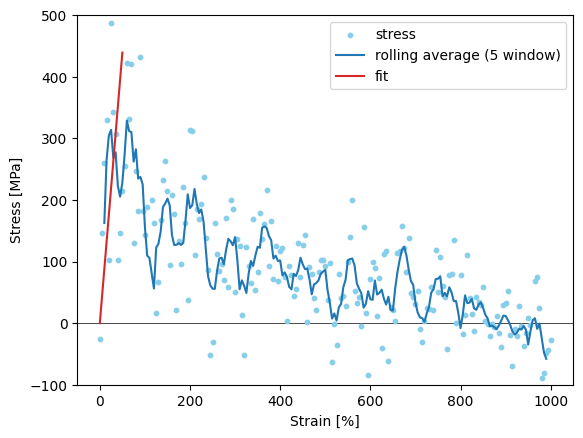

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df["Strain"], df["Stress"], label="stress", color="skyblue", s=10)
a, _ = np.polyfit(df["Strain"].iloc[:5], df["Stress"].iloc[:5], 1)
fit_strain = np.linspace(0, 50, 30)
ax.plot(df["Strain"].rolling(5).mean(), df["Stress"].rolling(5).mean(), label="rolling average (5 window)") 
ax.plot(fit_strain, a*fit_strain, label="fit", color="tab:red")
ax.axhline(y=0, color="black", linewidth=0.5, zorder=0)
ax.set_xlabel("Strain [%]")
ax.set_ylabel("Stress [MPa]")
ax.set_ylim(-100, 500)
ax.legend()